In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 200)
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import matplotlib_inline
from pathlib import Path
# get higher quality plots
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.5
import json
import cv2
from wordcloud import WordCloud, STOPWORDS

In [2]:
DATA_PATH = Path("/data/wr153")

# Features
* average number of words per page in each chapter
* average number of panels per page in each chapter
* ratio of images to words in each chapter
* colors used in memoir
* distribution of sentiment in overall memoir
    * positive, negative, neutral
* word cloud of ideas presented

In [7]:
img = cv2.imread(str(DATA_PATH.joinpath("images", "chapter_24", "223.jpg")))

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply a binary threshold
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

# Find contours
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter out small contours
min_area = 1000
contours = [c for c in contours if cv2.contourArea(c) > min_area]

# Count the remaining contours
num_panels = len(contours)

Text(0.5, 1.0, 'Panels Detected Image')

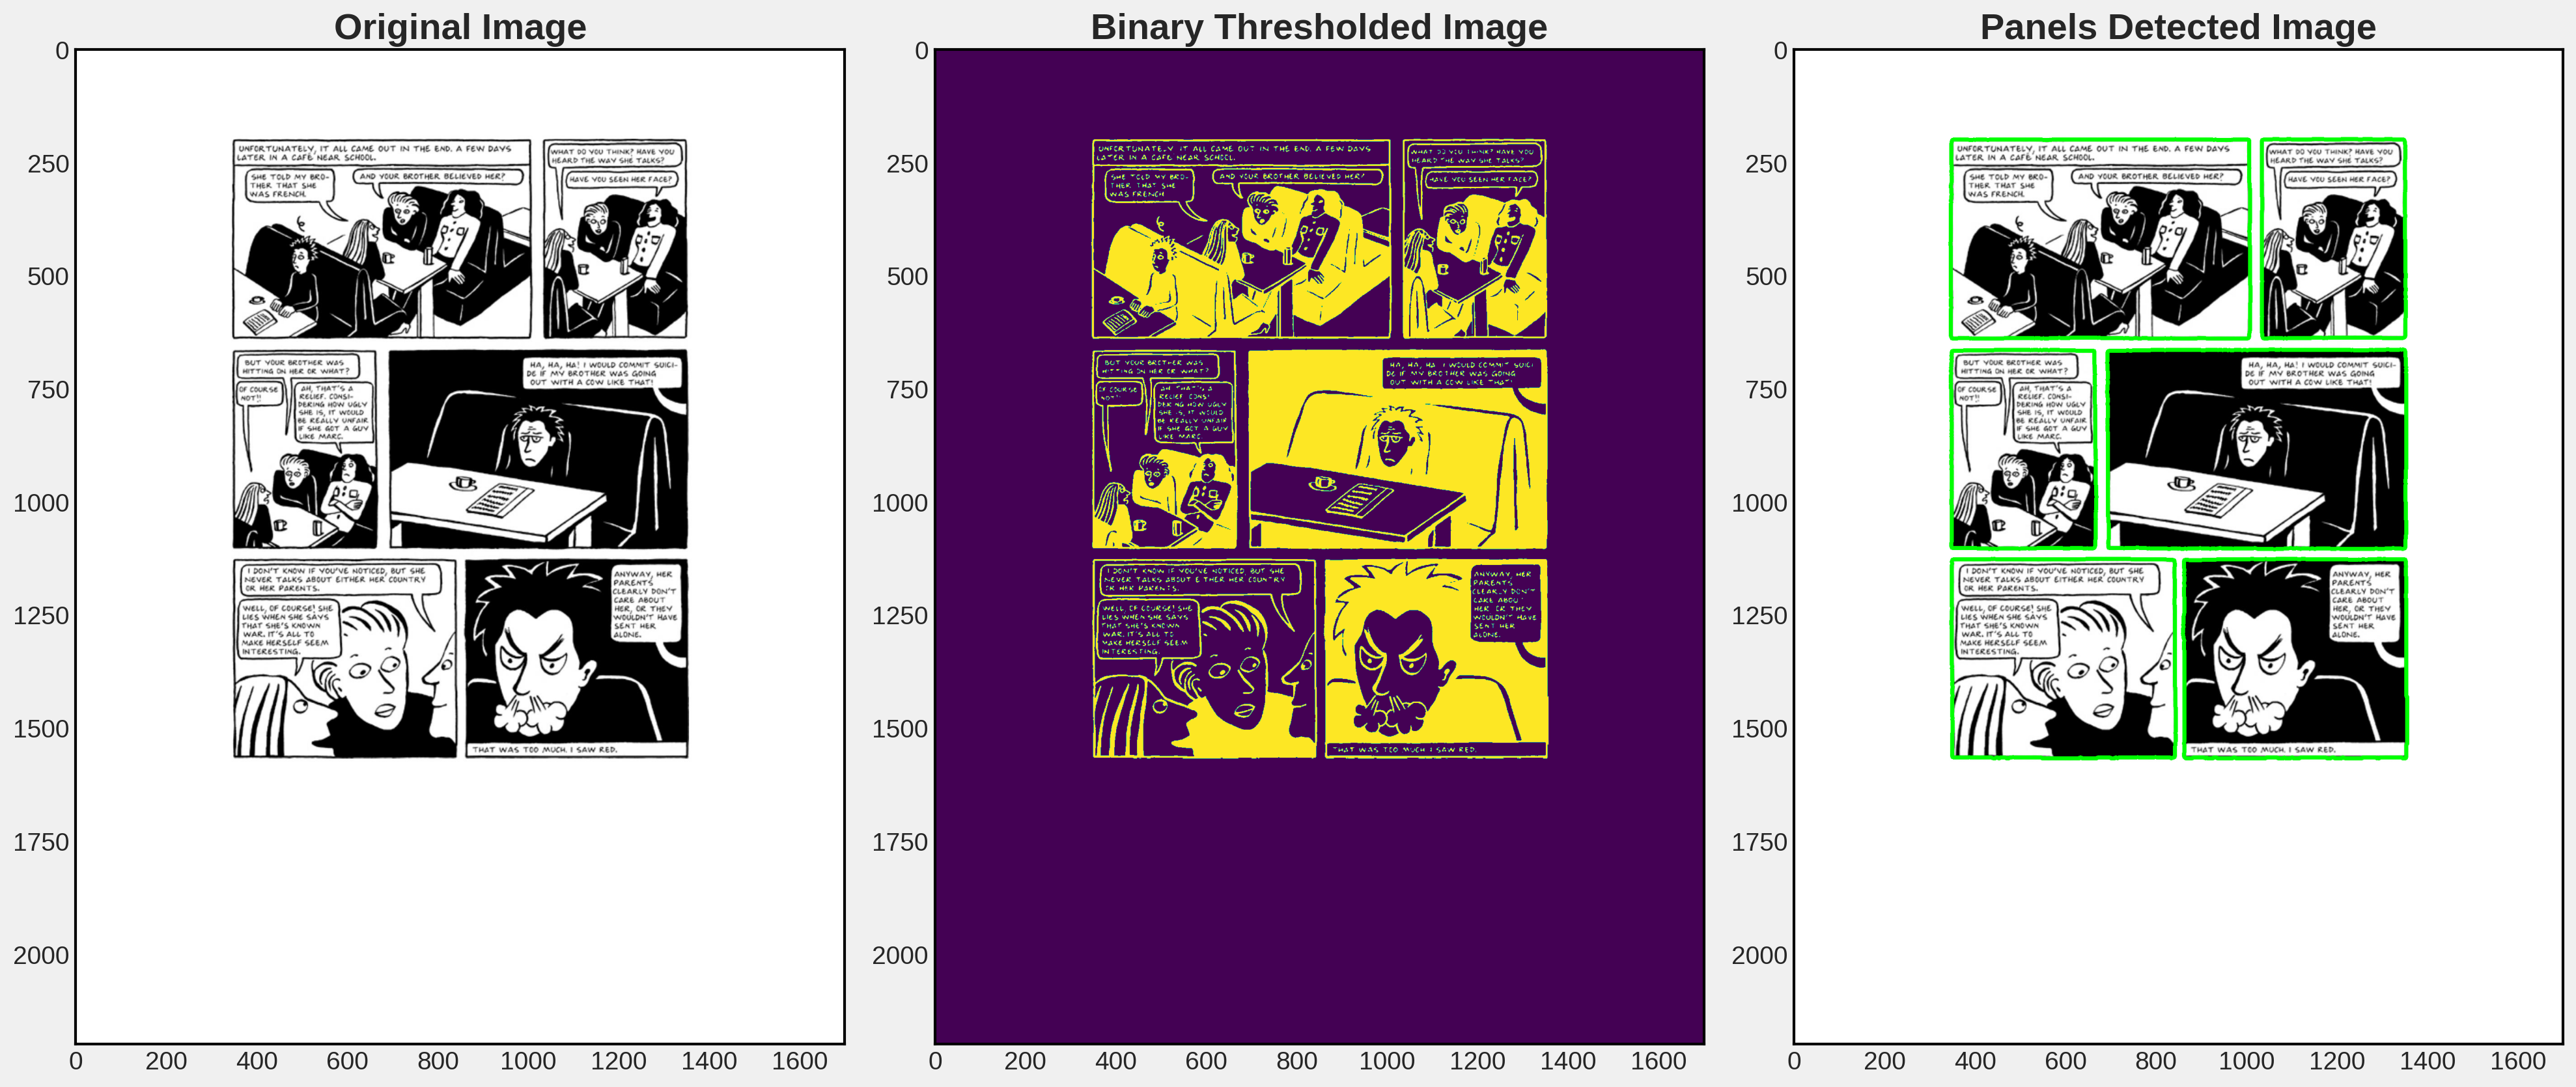

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
axs[0].imshow(img)
axs[0].grid(False)
axs[0].set_title("Original Image")
axs[1].imshow(thresh)
axs[1].grid(False)
axs[1].set_title("Binary Thresholded Image")
axs[2].imshow(cv2.drawContours(img, contours, -1, (0, 255, 0), 8))
axs[2].grid(False)
axs[2].set_title("Panels Detected Image")

In [9]:
def get_num_panels(im_path: Path) -> int:
    img = cv2.imread(str(im_path))

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply a binary threshold
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    # Find contours
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter out small contours
    min_area = 1000
    contours = [c for c in contours if cv2.contourArea(c) > min_area]

    # Count the remaining contours
    num_panels = len(contours)
    
    return num_panels

In [10]:
# generate statistics
data = {"chapter_title": [], "chapter_number": [], "avg_num_words": [], "avg_num_panels": []}
all_text = []
for f in DATA_PATH.joinpath("text").iterdir():
    if f.suffix == ".json":
        with open(f, "rb") as fp:
            d = json.load(fp)
            ch_title = d.pop(sorted(d, key=int)[0])
            data["chapter_title"].append(ch_title)
            n = int(f.stem.split("_")[1])
            data["chapter_number"].append(n)
            num_panels = 0
            l = 0
            for image in DATA_PATH.joinpath("images", f"chapter_{n}").iterdir():
                if image.suffix == ".jpg":
                    panels = get_num_panels(image)
                    num_panels += panels
                    l += 1
            data["avg_num_panels"].append(num_panels / l)
            # remove outliers for words
            remove_keys = []
            for key, val in d.items():
                if len(val.split()) <= 5:
                    remove_keys.append(key)
            for key in remove_keys:
                d.pop(key)
            data["avg_num_words"].append(sum(len(text.split()) for text in d.values()) / len(d))
            for text in d.values():
                all_text.append(text)

In [11]:
df = pd.DataFrame(data)

In [12]:
df.head()

chapter_title  chapter_number  avg_num_words  avg_num_panels
0       THE DOWRY              19     118.000000        6.416667
1  THE WATER CELL               3     110.875000        6.333333
2      THE MAKEUP              33     166.571429        6.250000
3        THE TRIP              10     144.125000        5.777778
4       THE F-14s              11     116.714286        6.750000

In [13]:
df["chapter_title"] = df["chapter_title"].str.title()
df["avg_word_to_image_ratio"] = df["avg_num_words"] / df["avg_num_panels"]

In [14]:
df["chapter_number"].to_numpy().astype(str)

array(['19', '3', '33', '10', '11', '20', '36', '24', '16', '34', '38',
       '23', '9', '31', '22', '35', '25', '8', '32', '28', '21', '4',
       '37', '26', '15', '17', '5', '13', '30', '14', '7', '1', '12',
       '29', '18', '2', '27', '6'], dtype='<U21')

In [18]:
df["chapter_title"] = df["chapter_title"] + " (" + df["chapter_number"].to_numpy().astype(str) + ")"

In [15]:
df = df.sort_values(by="chapter_number", ascending=False)

In [26]:
# df.sort_values(by="chapter_number", ascending=True).to_csv("chapter_agg_stats.csv", index=False)

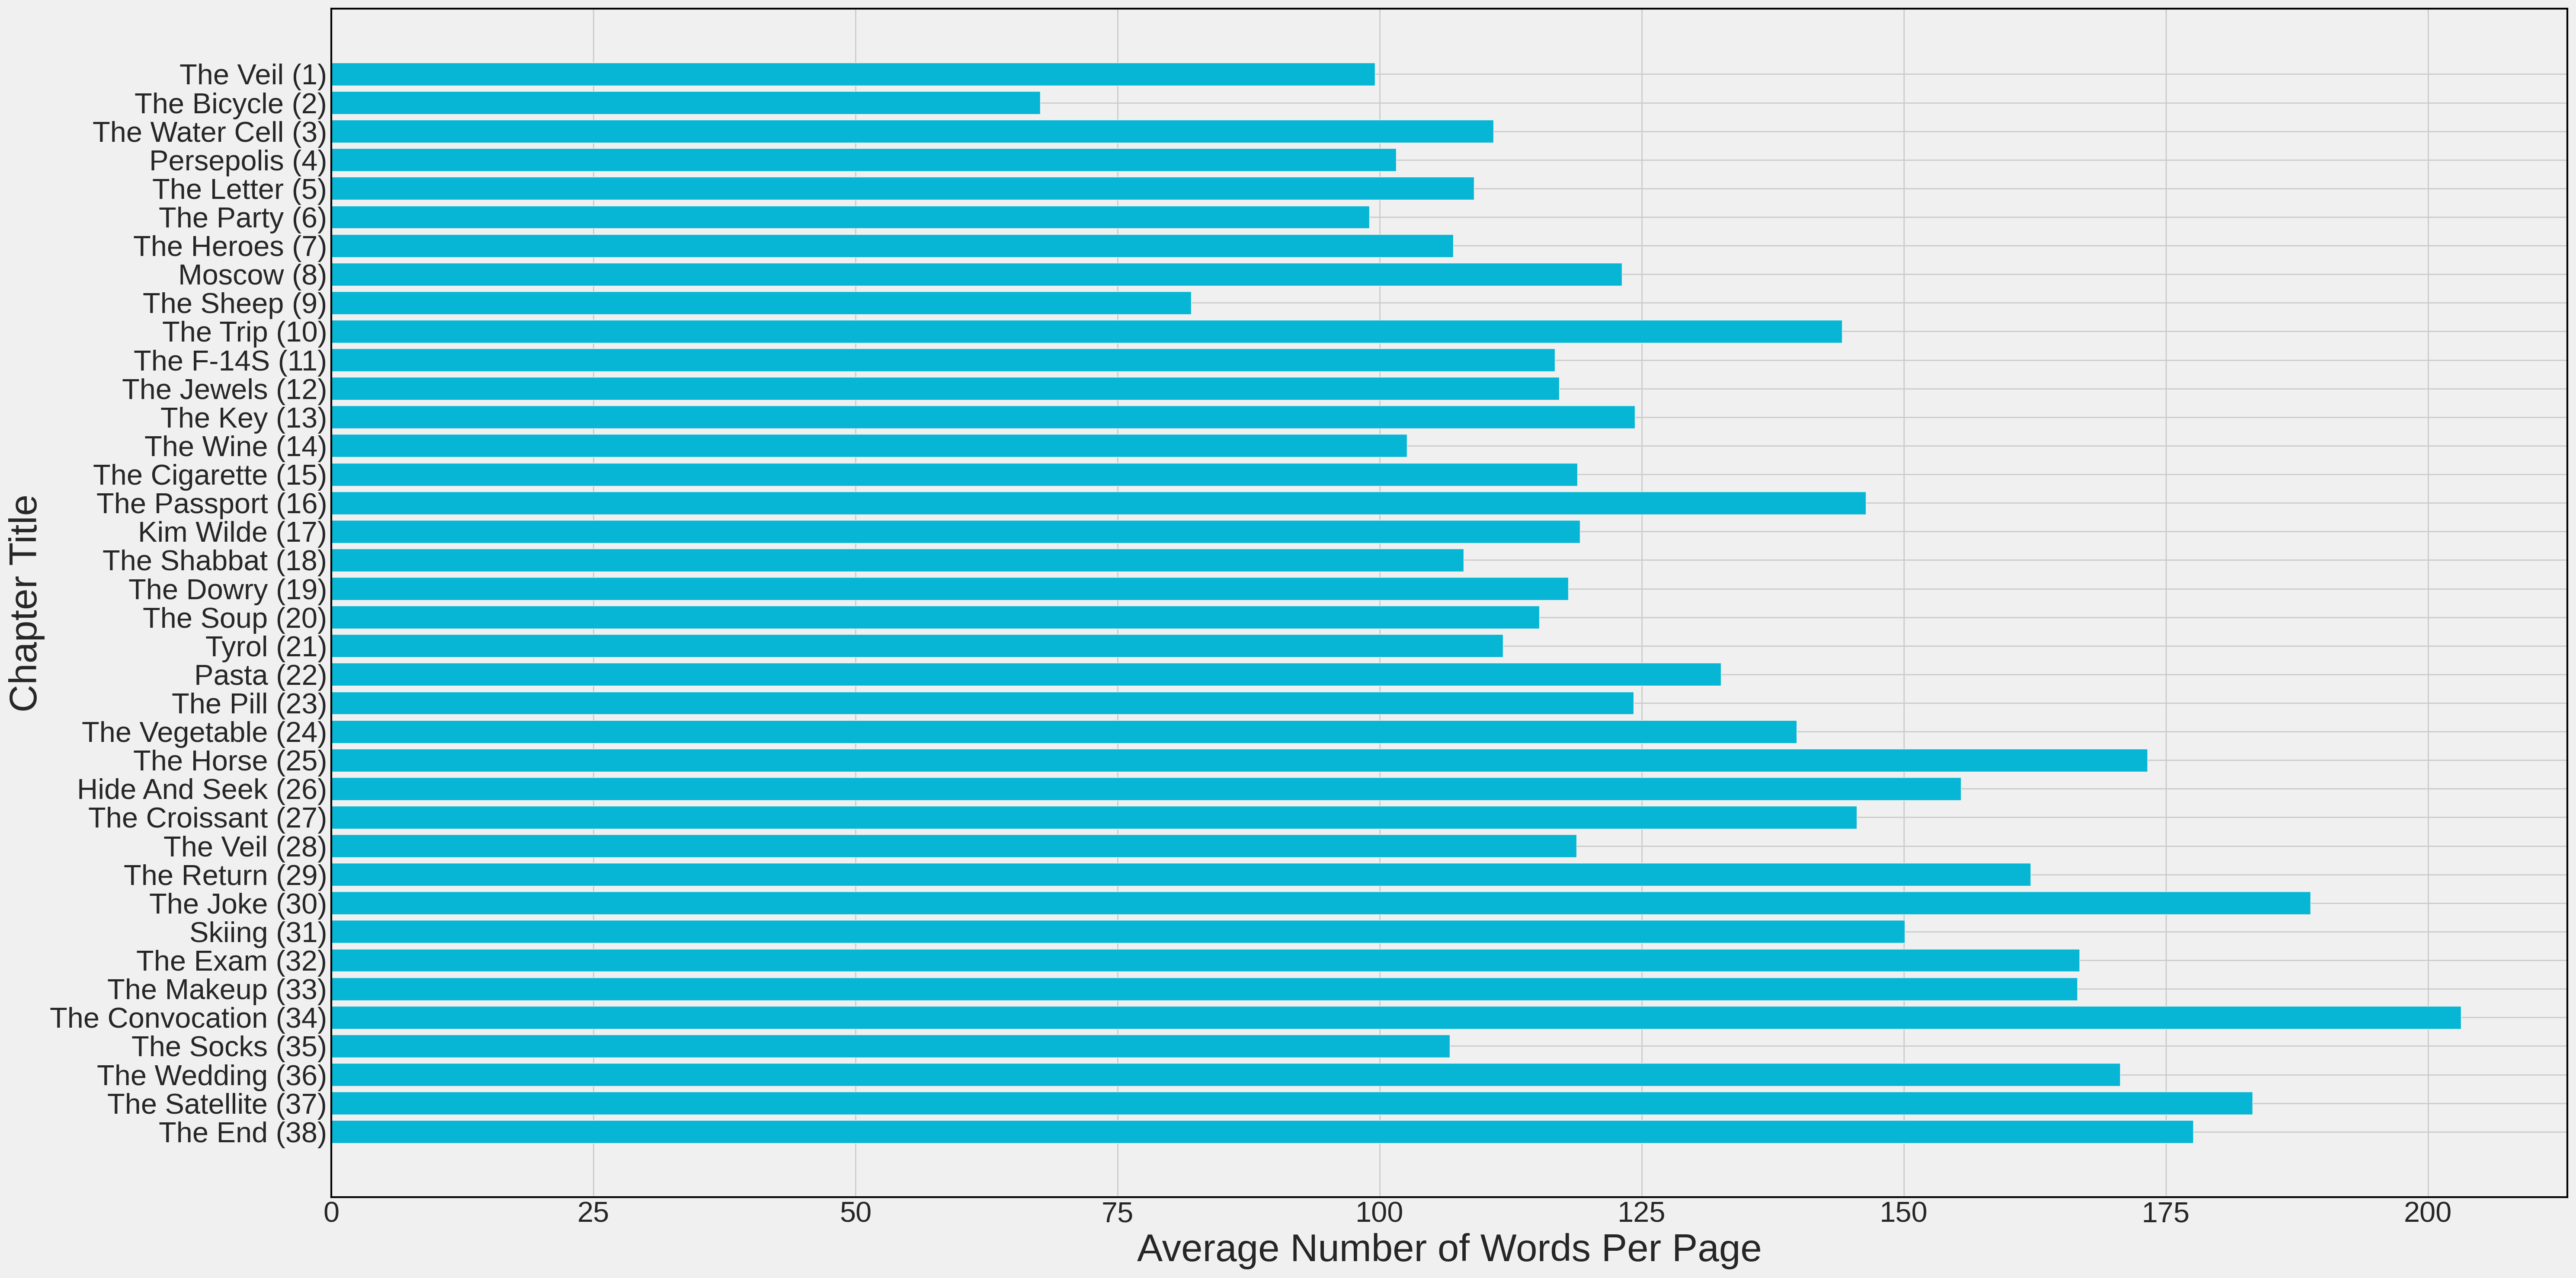

In [24]:
fig = plt.figure(figsize=(30, 15))
ax = fig.add_subplot(111)

# Create the horizontal bar chart
ax.barh(y=df["chapter_title"], width=df["avg_num_words"], color="#06B6D4")

# Set axis labels and title
ax.set_ylabel("Chapter Title", fontsize=32)
ax.set_xlabel("Average Number of Words Per Page", fontsize=32)
ax.tick_params(axis="both", labelsize=24)
# ax.set_title("Chapter vs Average Number of Words Per Page", fontsize=36)

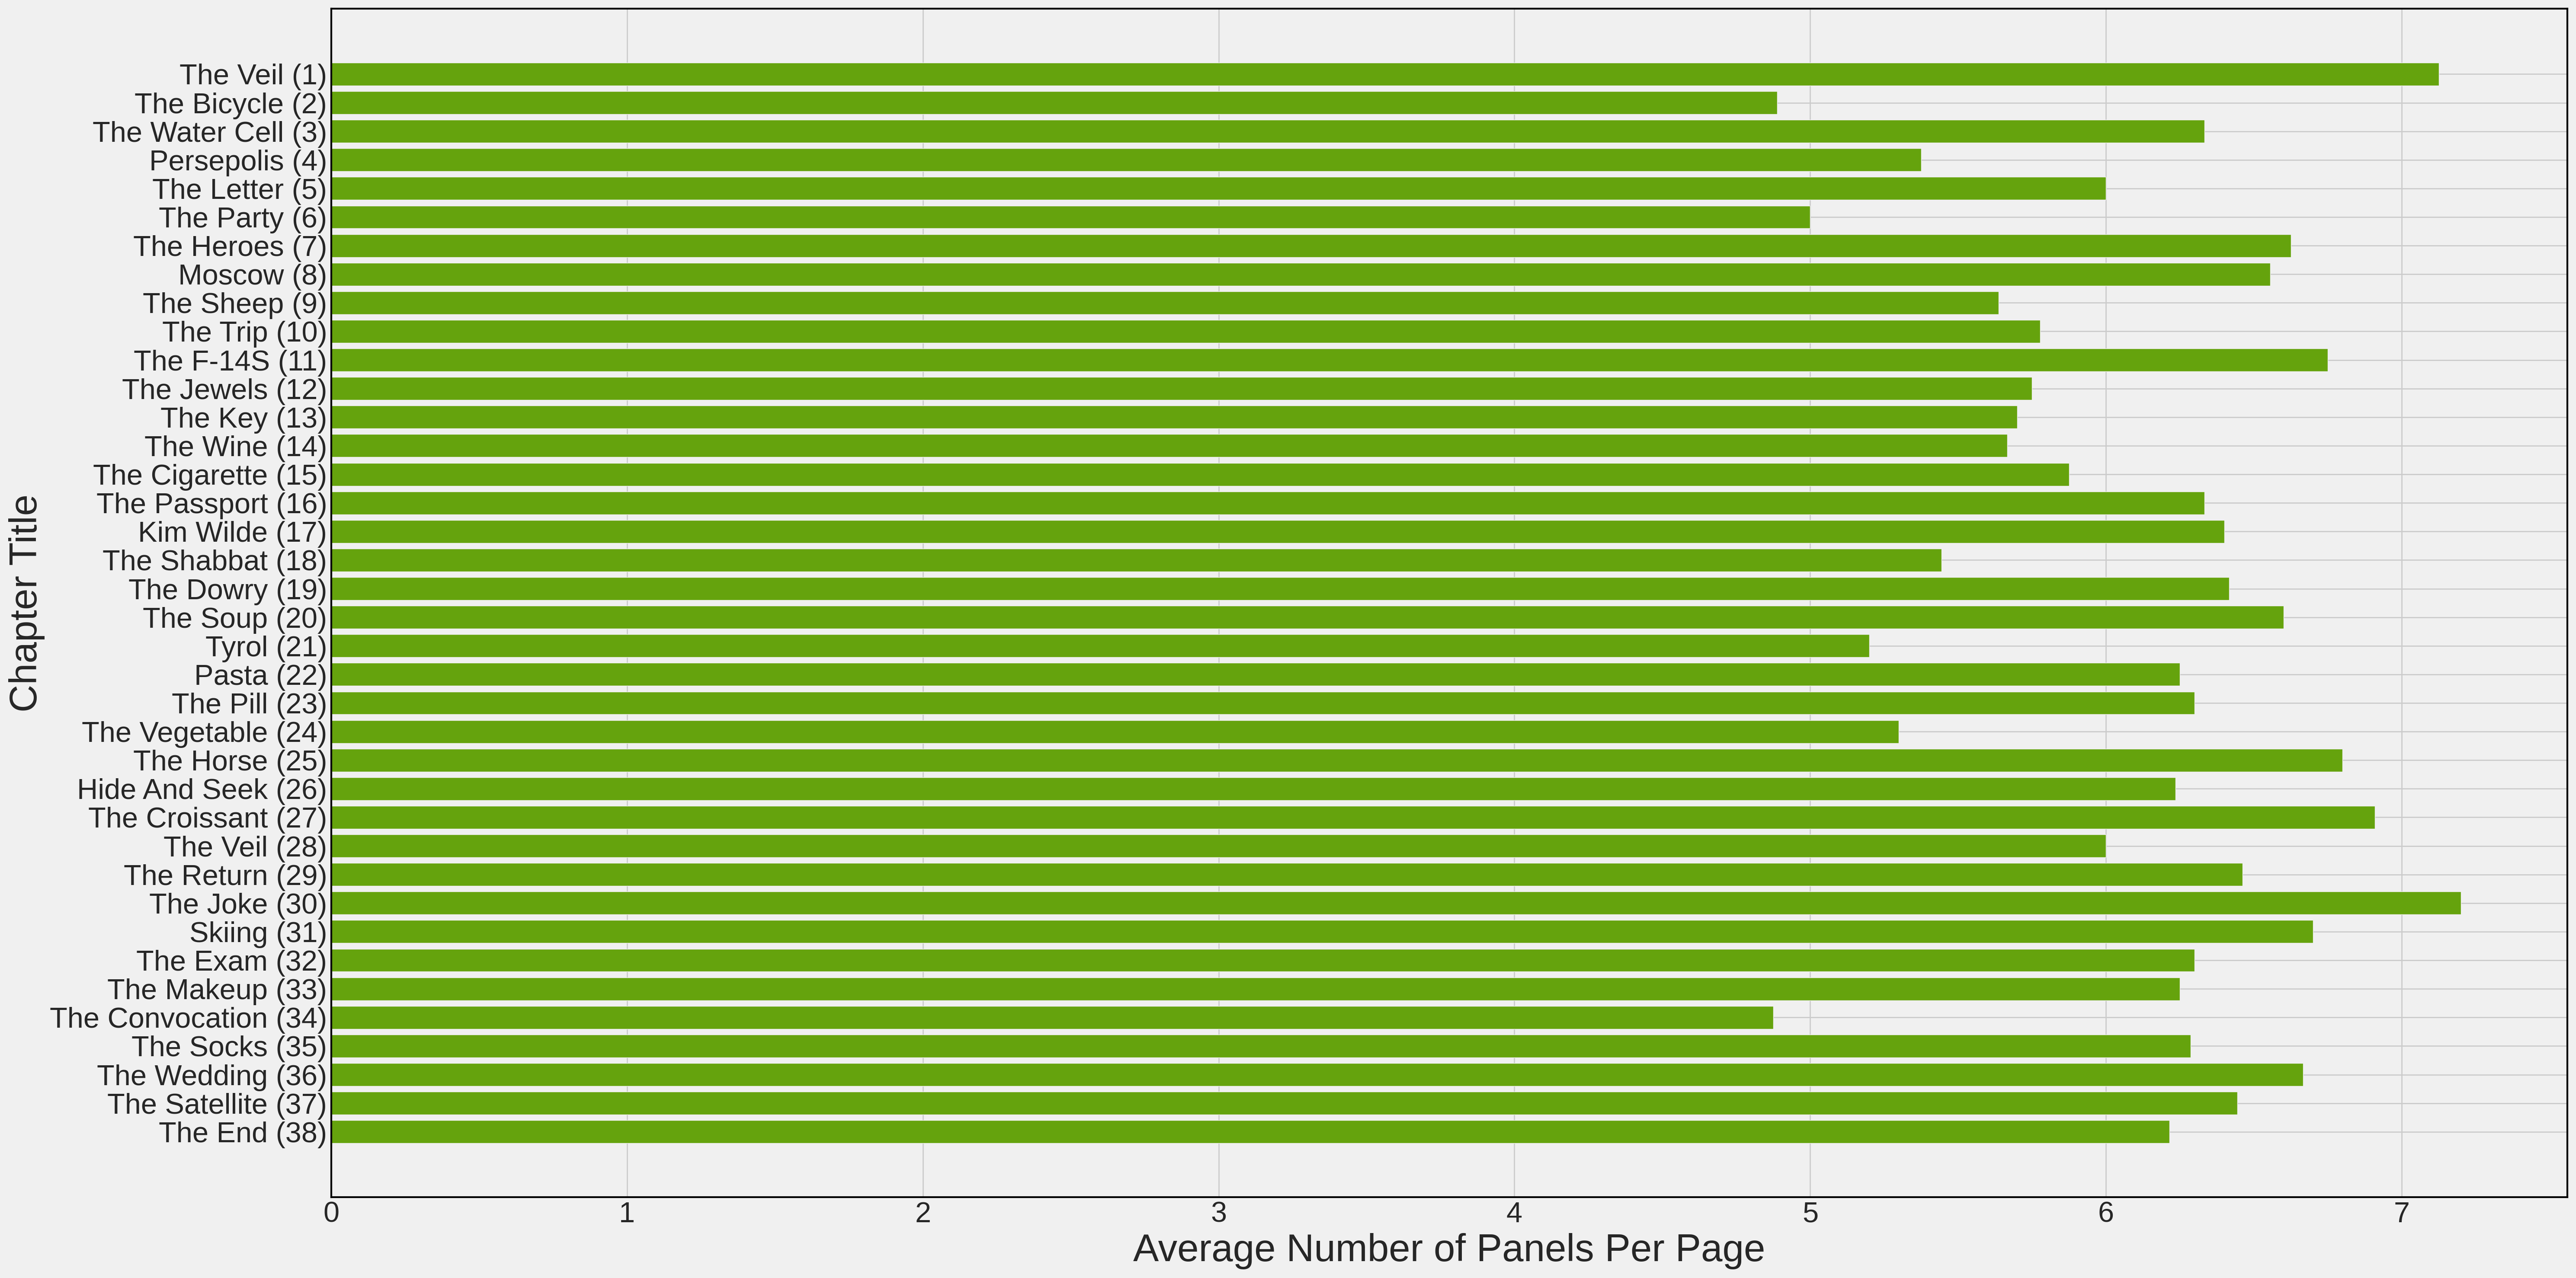

In [25]:
fig = plt.figure(figsize=(30, 15))
ax = fig.add_subplot(111)
ax.barh(y=df["chapter_title"], width=df["avg_num_panels"], color="#65A30D")
ax.set_ylabel("Chapter Title", fontsize=32)
ax.set_xlabel("Average Number of Panels Per Page", fontsize=32)
ax.tick_params(axis="both", labelsize=24)
# ax.set_title("Chapter vs Average Number of Panels", fontsize=36)

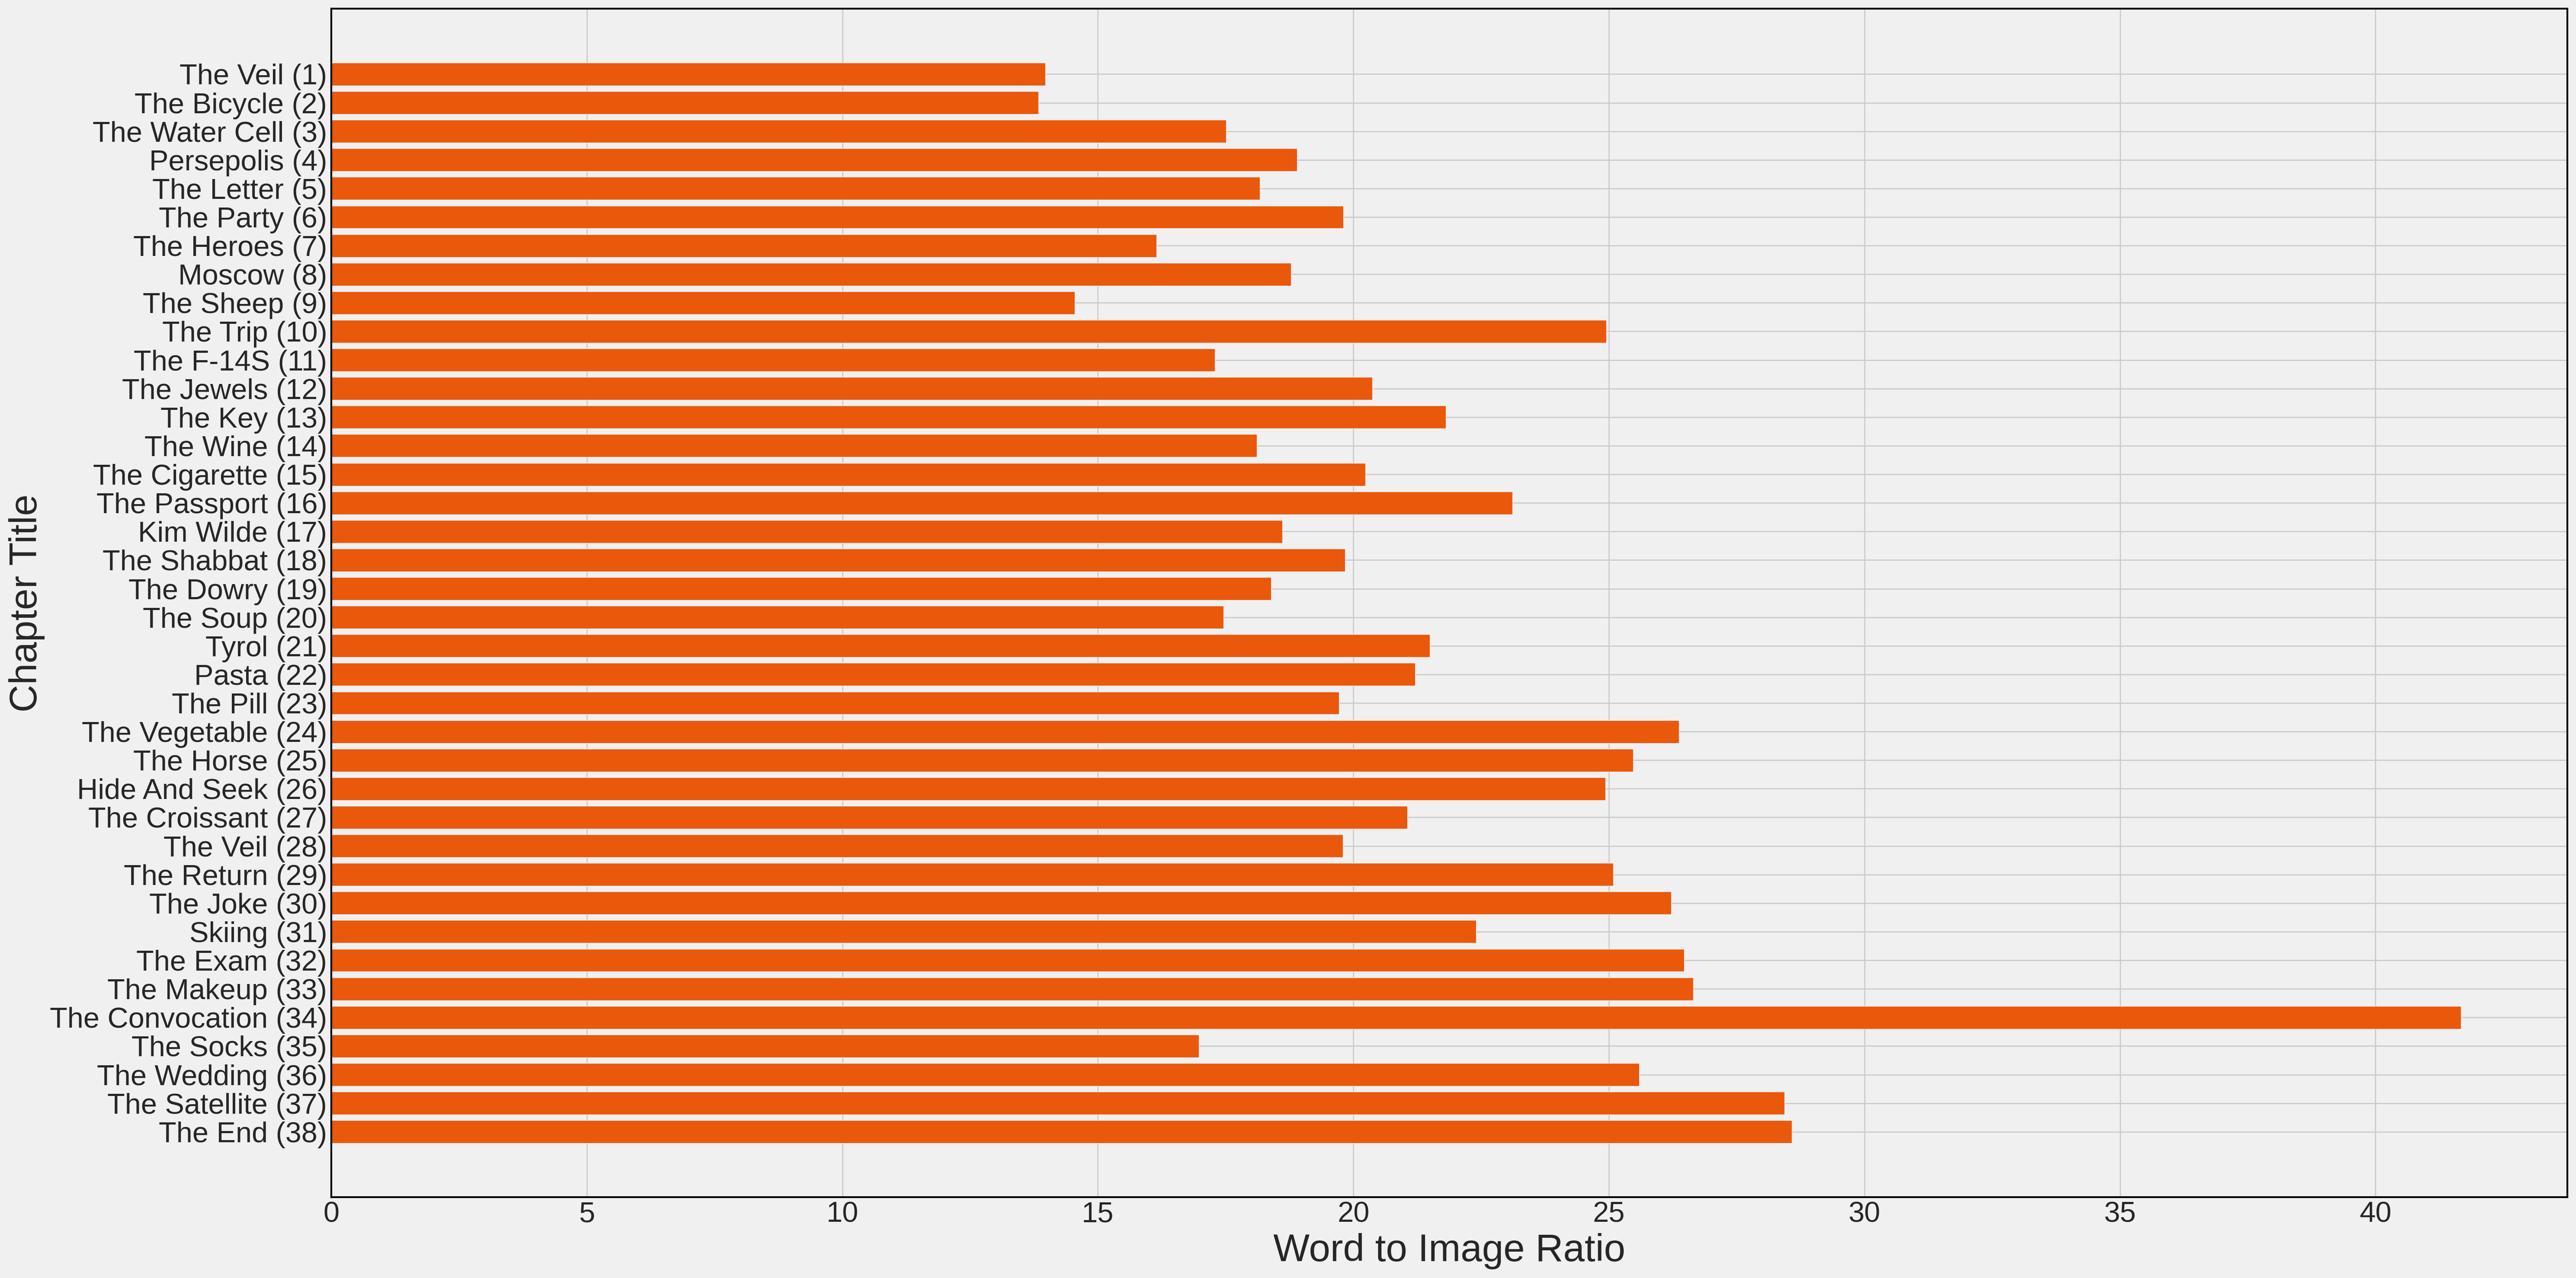

In [26]:
fig = plt.figure(figsize=(30, 15))
ax = fig.add_subplot(111)

# Create the horizontal bar chart
ax.barh(y=df["chapter_title"], width=df["avg_word_to_image_ratio"], color="#EA580C")

# Set axis labels and title
ax.set_ylabel("Chapter Title", fontsize=32)
ax.set_xlabel("Word to Image Ratio", fontsize=32)
ax.tick_params(axis="both", labelsize=24)
# ax.set_title("Chapter vs Average Word to Image Ratio", fontsize=36)

In [16]:
all_text = " ".join(all_text)

In [17]:
stopwords = STOPWORDS

wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=1000, width=800, height=400).generate(all_text)

In [18]:
common_words = pd.DataFrame([wordcloud.words_.keys(), wordcloud.words_.values()]).T

In [19]:
common_words.rename({0: "word", 1: "relative_frequency"}, axis=1, inplace=True)

In [20]:
common_words["relative_frequency"] = common_words["relative_frequency"].astype(float)

In [21]:
common_words["word"] = common_words["word"].str.lower()
common_words["relative_frequency"] = common_words["relative_frequency"].round(3)

In [22]:
common_words.iloc[:20]

word  relative_frequency
0      one               1.000
1     know               0.980
2      see               0.839
3    going               0.826
4     time               0.805
5   mother               0.752
6     want               0.752
7        u               0.698
8       go               0.691
9     come               0.691
10    even               0.597
11     day               0.570
12    well               0.570
13   think               0.530
14   right               0.523
15    will               0.517
16     say               0.503
17    went               0.490
18  father               0.490
19  people               0.483

In [27]:
# common_words.to_csv("common_words.csv", index=False)

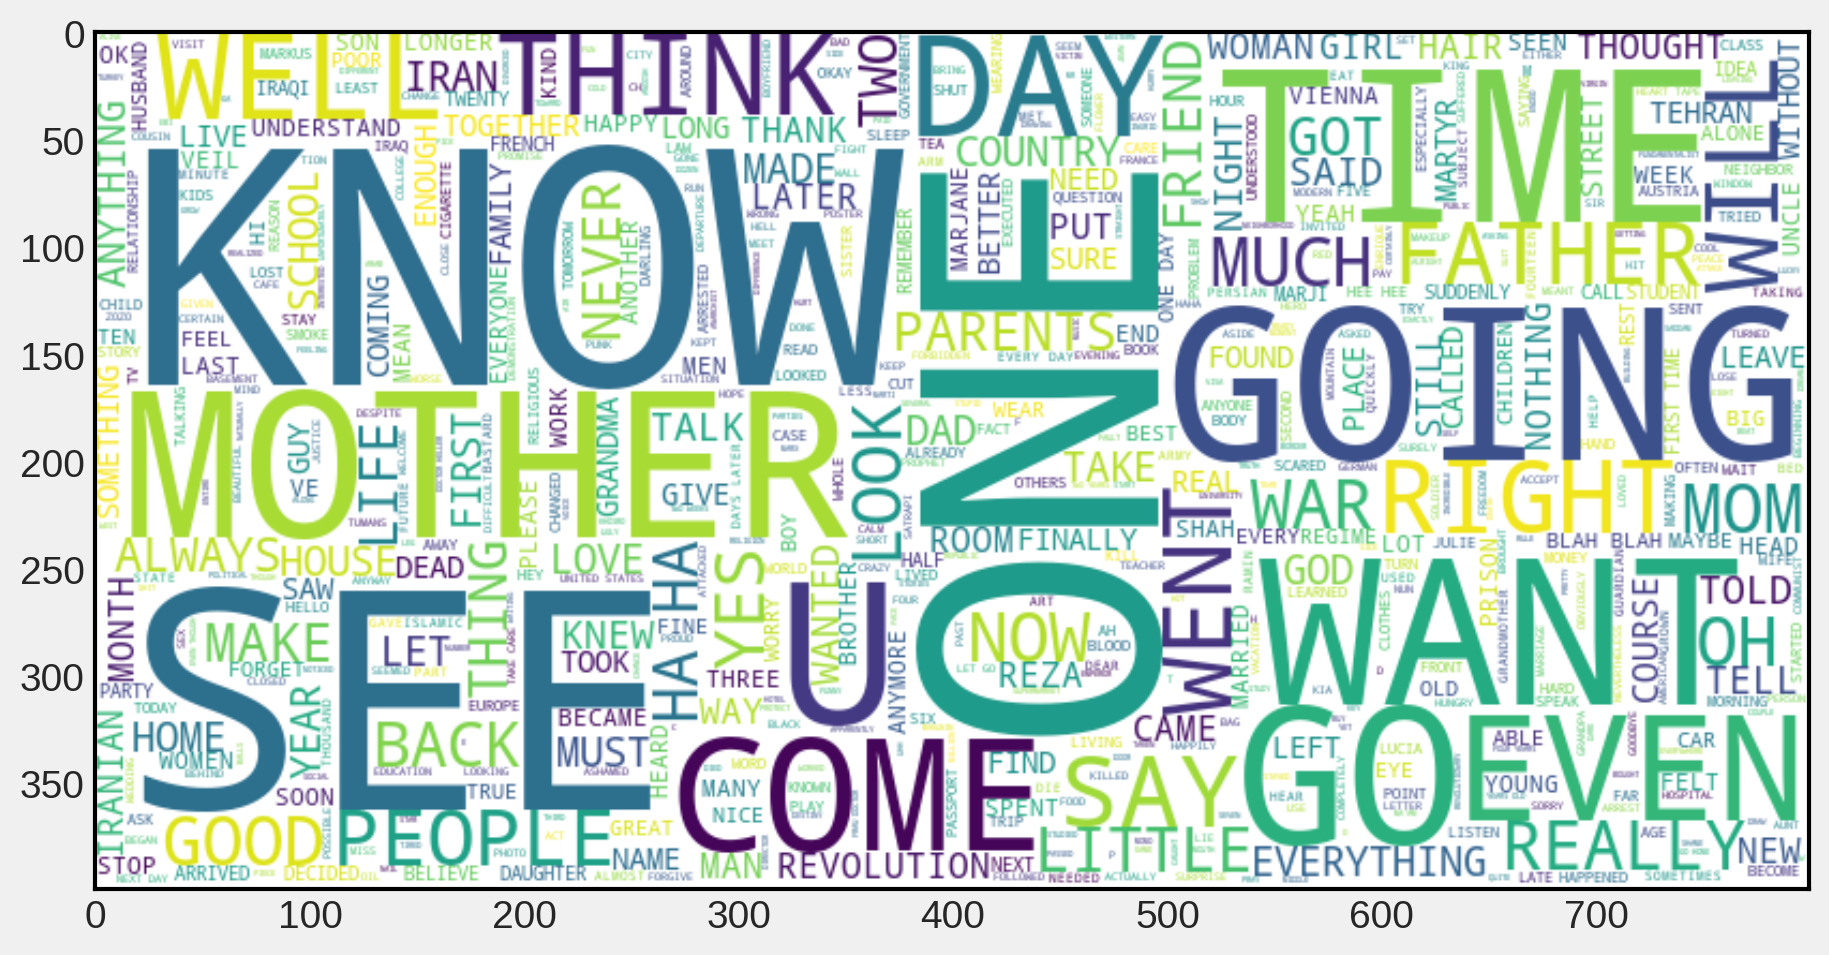

In [23]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.imshow(wordcloud, interpolation='bilinear')
ax.grid(False)

In [2]:
sentiment_count = pd.read_csv("sentiment_count.csv")

In [3]:
sentiment_count

negative  neutral  positive
0       131      148        55

Text(0, 0.5, 'Number of Pages')

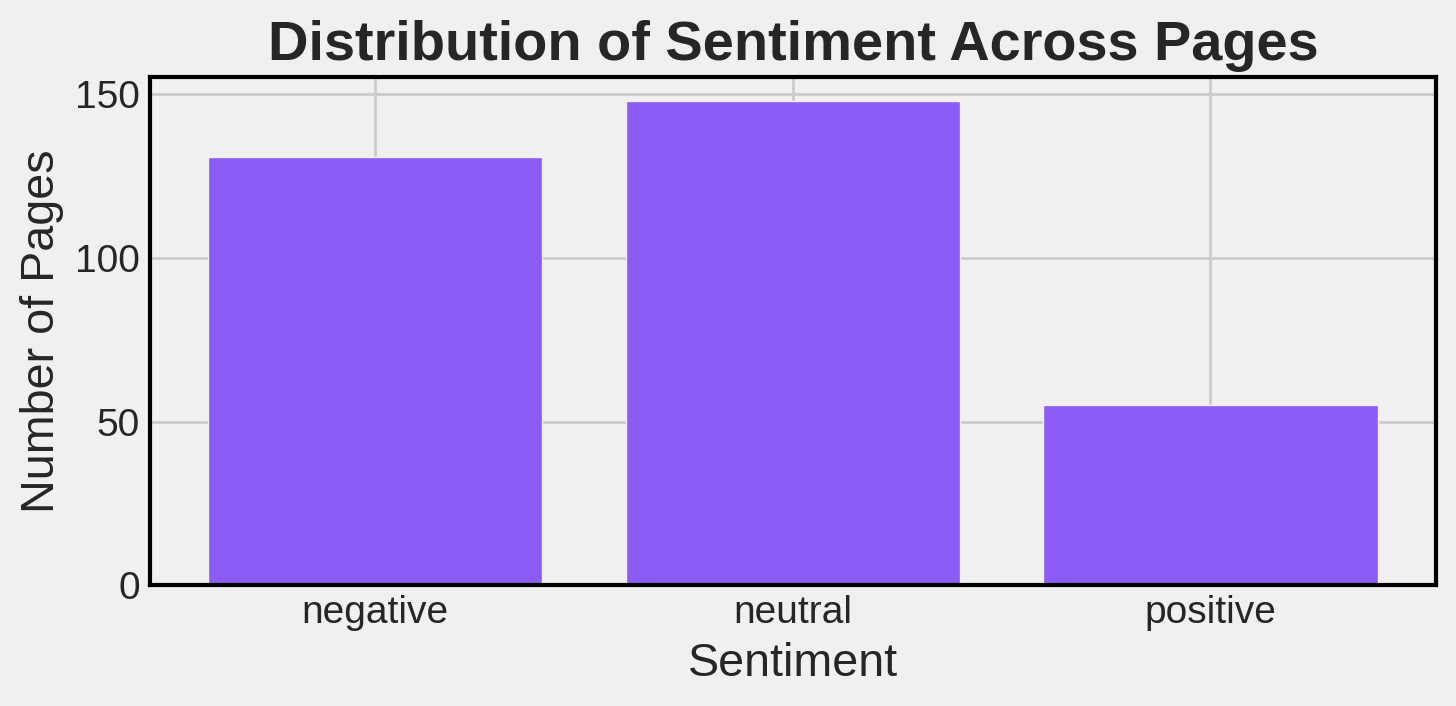

In [9]:
fig = plt.figure(figsize=(7.5, 3.75))
ax = fig.add_subplot(111)

ax.bar(x=sentiment_count.columns, height=sentiment_count.iloc[0], color="#8B5CF6")
ax.set_title("Distribution of Sentiment Across Pages")
ax.set_xlabel("Sentiment")
ax.set_ylabel("Number of Pages")

2136


(array([23., 64., 82., 76., 44., 35.,  6.,  2.,  1.,  1.]),
 array([  73. ,  279.3,  485.6,  691.9,  898.2, 1104.5, 1310.8, 1517.1,
        1723.4, 1929.7, 2136. ]),
 <BarContainer object of 10 artists>)

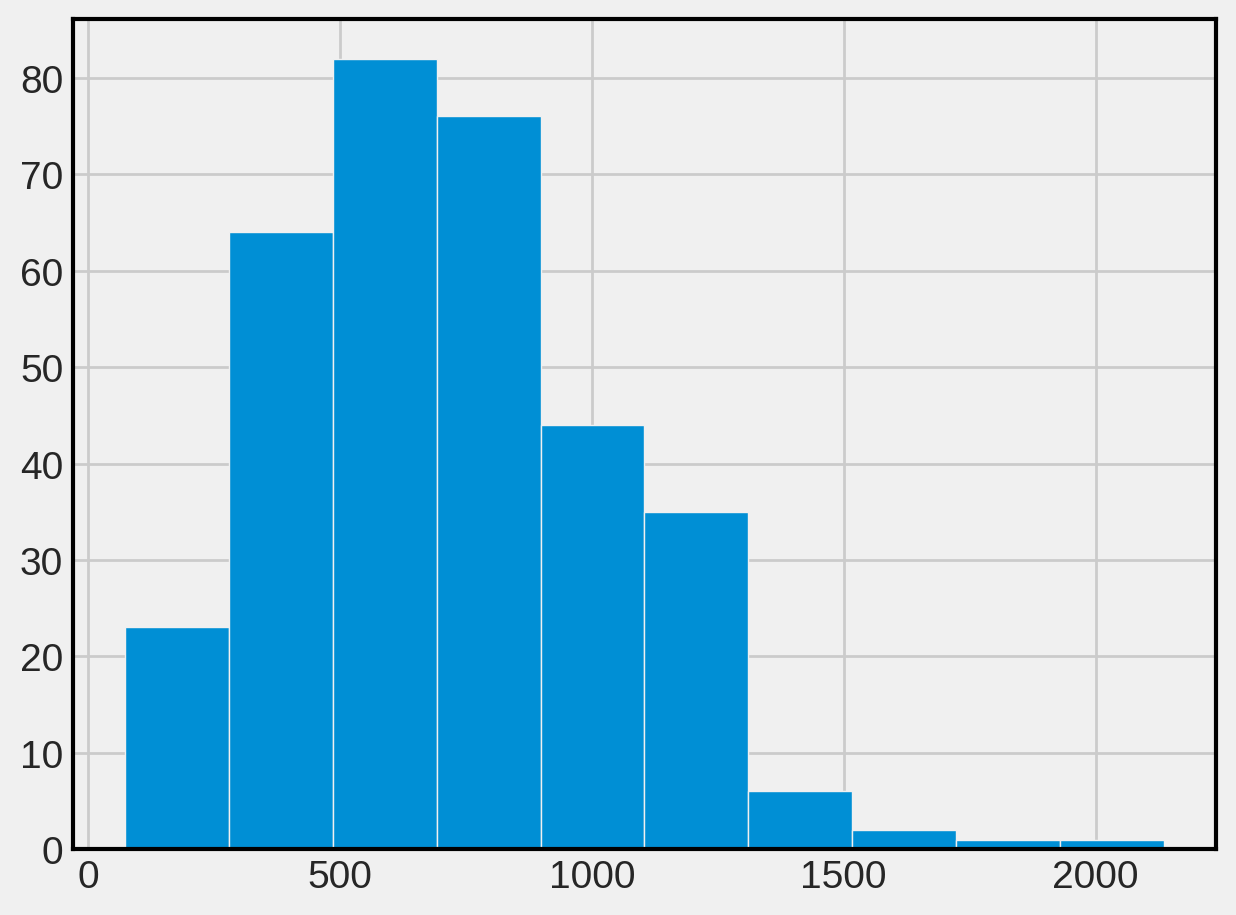

In [3]:
txt_list = []
for f in DATA_PATH.joinpath("text").iterdir():
    if f.suffix == ".json":
        with open(f, "rb") as fp:
            d = json.load(fp)
            ch_title = d.pop(sorted(d, key=int)[0])
            # remove outliers for words
            remove_keys = []
            for key, val in d.items():
                if len(val.split()) <= 5:
                    remove_keys.append(key)
            for key in remove_keys:
                d.pop(key)
            for text in d.values():
                txt_list.append(text)
                
print(max(len(t) for t in txt_list))
plt.hist(x=[len(t) for t in txt_list])